In [1]:
import h5py
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import os
from pathlib import Path
import pyfftw

import bacco

import sys
sys.path.append('/dipc/kstoreyf/muchisimocks/scripts')
import plotter
import plot_utils
import utils
import compute_statistics as cs
import data_loader
import generate_params as genp

%load_ext autoreload
%autoreload 2

2026-01-30 20:16:13.209441: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2026-01-30 20:16:13.209519: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2026-01-30 20:16:13.529676: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2026-01-30 20:16:14.182435: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-01-30 20:16:36.886284: W tensorflow/comp

# test on single

In [2]:
tag_params = '_p5_n10000'
idx_LH = 0

# change this directory path as needed
dir_mocks = f'/cosmos_storage/simulations/BaccoSims/muchisimocks/muchisimocks_lib{tag_params}'
#dir_mocks = f'/scratch/kstoreyf/muchisimocks/muchisimocks_lib{tag_params}'
subdir_prefix = 'LH'
fn_fields = f'{dir_mocks}/{subdir_prefix}{idx_LH}/bias_fields_eul_deconvolved_{idx_LH}.npy'
bias_terms_eul = np.load(fn_fields)


In [3]:
#the order is b1, b2, bs2, blaplacian
#bias_params = [1, 0, 0, 0]
bias_params = [1.2, 0.5, 0.25, 5]

# use 512 for normalization, because this is the original resolution of the mocks (they were downsampled to 128)
# this doesn't matter for visualization, but will when you go to compute statistics
n_grid_orig = 512
tracer_field = utils.get_tracer_field(bias_terms_eul, bias_params, n_grid_norm=n_grid_orig)

In [4]:
box_size = 1000 # Mpc/h
n_grid = 128 

In [5]:
params_df, param_dict_fixed = data_loader.load_cosmo_params(tag_params)
print(params_df)
param_dict = params_df.loc[idx_LH].to_dict()
cosmo = utils.get_cosmo(param_dict)

      omega_cold  sigma8_cold    hubble  omega_baryon        ns
0       0.236617     0.697564  0.663683      0.048591  0.957079
1       0.337168     0.793531  0.602884      0.052822  0.959740
2       0.285414     0.852452  0.730887      0.053568  0.969280
3       0.238496     0.686086  0.714819      0.050500  0.967325
4       0.274884     0.893641  0.600121      0.057412  0.981679
...          ...          ...       ...           ...       ...
9995    0.281629     0.682273  0.783502      0.051098  0.951428
9996    0.310038     0.842970  0.706149      0.053284  0.979408
9997    0.299789     0.865812  0.676875      0.057476  0.938394
9998    0.351611     0.858341  0.704226      0.045547  0.963179
9999    0.341659     0.786988  0.708020      0.054471  0.924276

[10000 rows x 5 columns]


In [6]:
matter_density_field = bias_terms_eul[1]

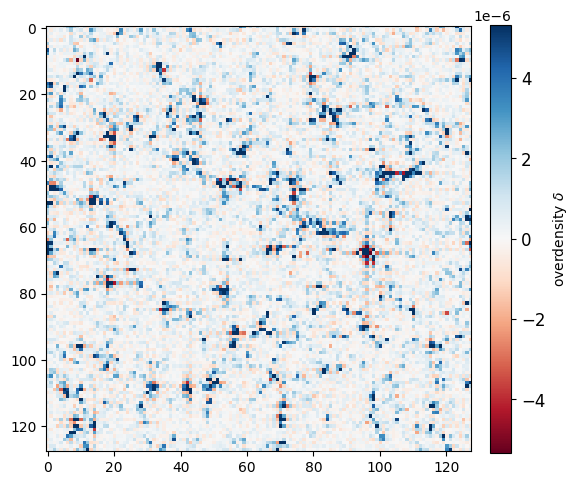

In [7]:
plotter.plot_field(tracer_field, overdensity=True)

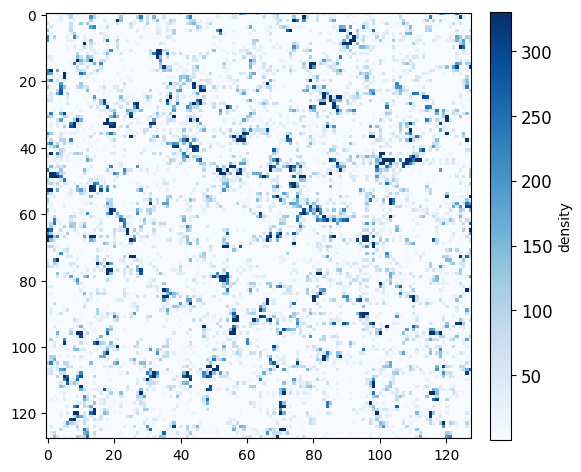

In [8]:
plotter.plot_field(matter_density_field, overdensity=False)

In [9]:
pk_obj = cs.compute_pk(tracer_field, cosmo, box_size, n_grid_orig)

Computing pk, using n_grid =  128


2026-01-30 20:17:55,447 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False
2026-01-30 20:17:56,467 bacco.statistics :  ...done in 1.02 s


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 8; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1 (grid1) 1 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.009066 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.048442 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000157 secs
bacco.power : Deallocating arrays


In [10]:
pgm_obj = cs.compute_pgm(tracer_field, matter_density_field/n_grid_orig**3, cosmo, box_size)

Computing pgm, using n_grid =  128


2026-01-30 20:17:58,669 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 8; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=0 deconvolve_grid2=0


2026-01-30 20:17:58,884 bacco.statistics :  ...done in 0.215 s


bacco.power : total mass 1 (grid1) 6.31307e-11 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.068139 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.074623 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000141 secs
bacco.power : Deallocating arrays


In [11]:
pmm_obj = cs.compute_pk(matter_density_field/n_grid_orig**3, cosmo, box_size)

Computing pk, using n_grid =  128


2026-01-30 20:18:01,037 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False
2026-01-30 20:18:01,224 bacco.statistics :  ...done in 0.188 s


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 8; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 6.31307e-11 (grid1) 6.31307e-11 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.025464 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.072149 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000251 secs
bacco.power : Deallocating arrays


/tmp/ipykernel_256312/2410430002.py:17: RuntimeWarning: invalid value encountered in divide
  frac_diff = (pk_obj['pk'] - pgm_obj['pk']) / pgm_obj['pk']


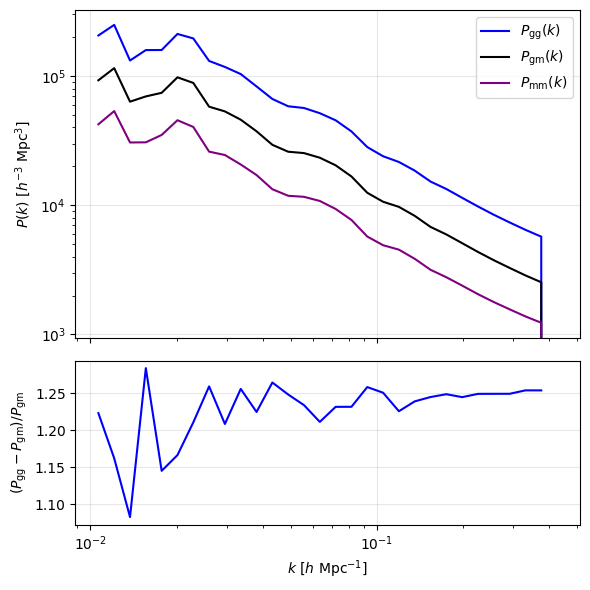

In [12]:
# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 6), sharex=True, gridspec_kw={'height_ratios': [2, 1]})

# Upper panel: power spectra
#ax1.plot(pgm_obj['k'], pgm_obj['pk'], label=r'$P_{\rm gm}(k)$', color='blue')
ax1.plot(pk_obj['k'], pk_obj['pk'], label=r'$P_{\rm gg}(k)$', color='blue')
ax1.plot(pgm_obj['k'], pgm_obj['pk'], label=r'$P_{\rm gm}(k)$', color='k')
ax1.plot(pmm_obj['k'], pmm_obj['pk'], label=r'$P_{\rm mm}(k)$', color='purple')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_ylabel(r'$P(k) \,\, [h^{-3} \,\, {\rm Mpc}^3]$')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Lower panel: fractional difference
# Assume k bins are the same
frac_diff = (pk_obj['pk'] - pgm_obj['pk']) / pgm_obj['pk']

ax2.plot(pgm_obj['k'], frac_diff, color='blue', linewidth=1.5)
#ax2.axhline(y=0, color='k', linestyle='--', linewidth=0.8, alpha=0.5)
ax2.set_xscale('log')
ax2.set_xlabel(r'$k \,\, [h \,\, {\rm Mpc}^{-1}]$')
ax2.set_ylabel(r'$(P_{\rm gg} - P_{\rm gm}) / P_{\rm gm}$')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# shame

In [13]:
from process_catalogs import round_to_nearest_even

In [14]:
data_mode = 'shame'
cosmo = utils.get_cosmo(utils.cosmo_dict_shame)
box_size_mock = 1024.0
box_size_muchisimocks = 1000.0
n_grid_orig = 512
n_grid = 128
n_grid_orig_mock = round_to_nearest_even(box_size_mock / (box_size_muchisimocks/n_grid_orig))
n_grid_mock = round_to_nearest_even(box_size_mock / (box_size_muchisimocks/n_grid))
print(n_grid_orig_mock, n_grid_mock)

524 132


In [15]:
tag_mock = '_nbar0.00022'
fn_cat0_mesh = f'../data/data_{data_mode}/data{tag_mock}/tracer_field_phase0.npy'
tracer_field0 = np.load(fn_cat0_mesh)
print(tracer_field0.shape)

(132, 132, 132)


In [16]:
dir_sim = '/cosmos_storage/simulations/BaccoSims/Rings/N3072_L1024/Planck_N3072_L1024.0_output/0.00'
snapnum = 49 #z=0, i believe
halo_file = f"groups_{snapnum:03}/fof_subhalo_history_tab_orph_wweight_{snapnum:03}"
sim = bacco.Simulation(basedir=dir_sim, 
                    halo_file=halo_file,
                    )
    

2026-01-30 20:18:18,932 bacco.sims : Initialising simulation Default
2026-01-30 20:18:18,933 bacco.sims : try /cosmos_storage/simulations/BaccoSims/Rings/N3072_L1024/Planck_N3072_L1024.0_output/0.00/groups_049/fof_subhalo_history_tab_orph_wweight_049
2026-01-30 20:18:18,937 bacco.sims : Loading /cosmos_storage/simulations/BaccoSims/Rings/N3072_L1024/Planck_N3072_L1024.0_output/0.00/groups_049/fof_subhalo_history_tab_orph_wweight_049
2026-01-30 20:18:18,942 bacco.cosmo :    initialization took 0.000 secs
2026-01-30 20:18:18,999 bacco.sims : ...done in 0.0109 s


In [17]:
# sim_dir = '/cosmos_storage/simulations/BaccoSims/Rings/N3072_L1024/Planck_N3072_L1024.0_output/0.00'
# z = '0.0'
# a = 1/(1+np.float64(z))

# sim = bacco.Simulation(basedir=sim_dir, halo_file='groups_%03d/fof_subhalo_history_tab_orph_wweight_%03d'%(49, 49),
#                        use_orphans=True, closest_expfactor = 1/(1+float(z)),usememcache=True)

In [18]:
BoxSize = sim.header['BoxSize']
print(BoxSize)
assert BoxSize == box_size_mock

1024.0


In [19]:
dens_field_ngorig = bacco.statistics.compute_mesh(ngrid=n_grid_orig_mock, box=box_size_mock, 
                                    pos=sim.sdm['pos'], 
                                    deposit_method='cic', 
                                    interlacing=False,
                                    cosmology=sim.Cosmology
                                    )

2026-01-30 20:18:24,884 bacco.sims : Reconstructing sDM
2026-01-30 20:18:25,756 bacco.sims : Reading 251616300 items for sDM/ih_pos
2026-01-30 20:18:32,918 bacco.sims : Reading 57955287 items for GroupPos
2026-01-30 20:18:36,660 bacco.sims : Reading 251616300 items for sDM/ih_vel
2026-01-30 20:18:42,898 bacco.sims : Reading 57955287 items for GroupVel
2026-01-30 20:18:44,972 bacco.sims : Reading 251616300 items for sDM/offset
2026-01-30 20:19:00,829 bacco.sims : Reading 251616300 items for sDM/pos
2026-01-30 20:19:12,871 bacco.sims : Reading 251616300 items for sDM/vel
2026-01-30 20:19:25,615 bacco.sims : Reading 251616300 items for sDM/ih_ids
2026-01-30 20:19:31,224 bacco.sims : Reading 251616300 items for sDM/ids
2026-01-30 20:19:41,281 bacco.sims : Done reconstructing sDM
2026-01-30 20:19:41,282 bacco.statistics : Computing cic mesh with ngrid=524 and interlacing=False
2026-01-30 20:19:41,283 bacco.statistics : starting deposit 1
2026-01-30 20:19:47,530 bacco.statistics :  mesh done

bacco.mesh : boxsize=1024.000000 ngrid=524, nthreads=8, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 548.9 Mb
bacco.mesh : binning of 452984832 particles (1 with mass)
bacco.mesh : Using mass = 1.000000


In [20]:
# Remove high-k modes to downsample
dens_field_kcut = utils.remove_highk_modes(dens_field_ngorig[0], box_size_mock=box_size_mock, n_grid_target=n_grid_mock)

# tested in data_creation_pipeline that doing kcut then deconvolve is basically equivalent to deconvolve then kcut,
# and much faster
import bacco.probabilistic_bias as pb
dens_field_kcut_deconvolved = pb.convolve_linear_interpolation_kernel(dens_field_kcut, 
                                                                    npix=n_grid_orig_mock, mode="deconvolve")

/tmp/ipykernel_256312/728486832.py:7: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  dens_field_kcut_deconvolved = pb.convolve_linear_interpolation_kernel(dens_field_kcut,


In [21]:
dens_field0 = dens_field_kcut_deconvolved
print(dens_field0.shape)

(132, 132, 132)


In [22]:
# #dens_field0 = dens_field0_kcut_deconvolved
# fn_dens0_mesh = f'../data/data_{data_mode}/dens_mesh_phase0.npy'
# dens_field0 = np.load(fn_dens0_mesh)
# print(dens_field0.shape)

In [23]:
dens_lin = sim.get_linear_field(ngrid=n_grid_orig_mock, quantity='delta')

2026-01-30 20:20:06,235 bacco.cosmo :    computed CAMB power spectrum at z=0.00 in 0.253 secs
2026-01-30 20:20:06,237 bacco.cosmo :    created Pk(z=0) tab from k 7.38116359570995e-05 to 100000.0 h/Mpc


bacco.lss_scaler : 291 P(k) values; Di = (1.000000, 1.000000, 1.000000, 1.000000); nthreads =8; seed =-406168 
bacco.lss_scaler: start computing linear field...
bacco.lss_scaler: seed =-406168 ngrid=524 pkfixed=1 phase=0.000000, phase_type=0; precision=single 
bacco.lss: computing seed table


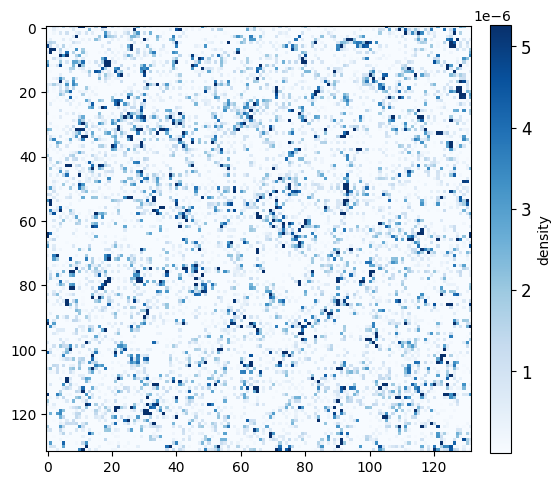

In [24]:
plotter.plot_field(tracer_field0, overdensity=False)

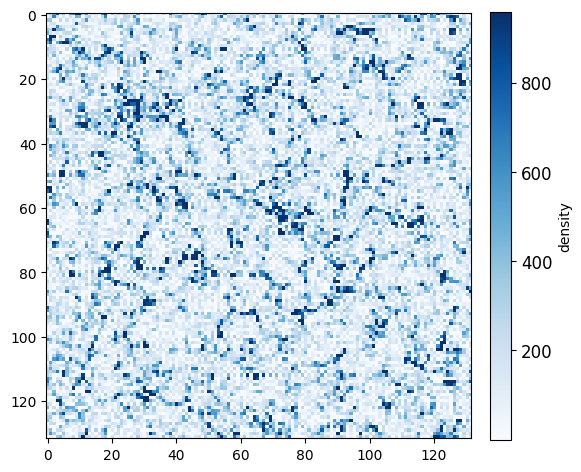

In [25]:
plotter.plot_field(dens_field0, overdensity=False)

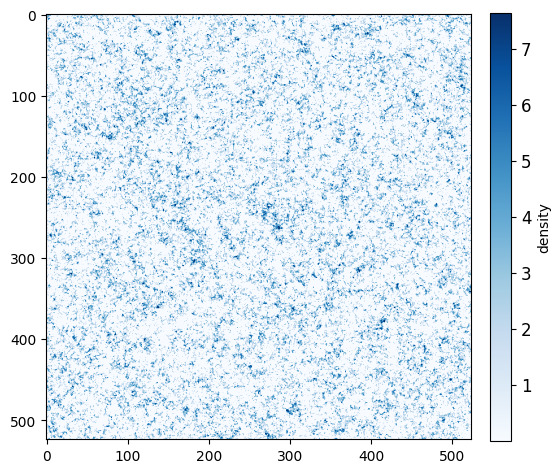

In [26]:
plotter.plot_field(dens_lin, overdensity=False)

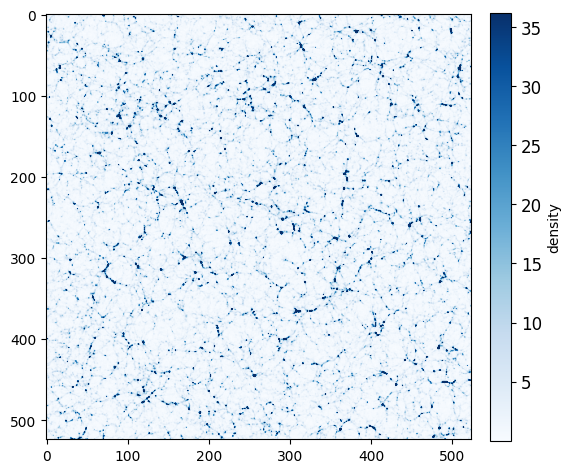

In [27]:
plotter.plot_field(dens_field_ngorig[0], overdensity=False)

In [28]:
pk_obj_shame = cs.compute_pk(tracer_field0, cosmo, box_size_mock, n_grid_orig_mock)

Computing pk, using n_grid =  132


2026-01-30 20:20:25,482 bacco.statistics : Computing the power spectrum with ngrid=132 and interlacing=False
2026-01-30 20:20:25,884 bacco.statistics :  ...done in 0.402 s


bacco.power : boxsize 1024.000000; ngrid 132; nthreads 8; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass -6.16393e-11 (grid1) -6.16393e-11 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.013937 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.079384 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000145 secs
bacco.power : Deallocating arrays


In [29]:
pgm_obj_shame = cs.compute_pgm(tracer_field0, dens_field0/np.sum(dens_field0), cosmo, box_size_mock, n_grid_orig_mock)

Computing pgm, using n_grid =  132


2026-01-30 20:20:27,399 bacco.statistics : Computing the power spectrum with ngrid=132 and interlacing=False
2026-01-30 20:20:27,508 bacco.statistics :  ...done in 0.109 s


bacco.power : boxsize 1024.000000; ngrid 132; nthreads 8; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass -6.16393e-11 (grid1) 1 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.017703 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.047572 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000412 secs
bacco.power : Deallocating arrays


In [30]:
pmm_obj_shame_lin = cs.compute_pk(dens_lin/n_grid_orig_mock**3, cosmo, box_size_mock)

Computing pk, using n_grid =  524


2026-01-30 20:20:29,672 bacco.statistics : Computing the power spectrum with ngrid=524 and interlacing=False


bacco.power : boxsize 1024.000000; ngrid 524; nthreads 8; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass -3.50489e-10 (grid1) -3.50489e-10 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 2.043047 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.300689 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000313 secs
bacco.power : Deallocating arrays


2026-01-30 20:20:37,768 bacco.statistics :  ...done in 8.1 s


In [31]:
pmm_obj_shame = cs.compute_pk(dens_field0/np.sum(dens_field0), cosmo, box_size_mock, n_grid_orig_mock)

Computing pk, using n_grid =  132


2026-01-30 20:20:39,470 bacco.statistics : Computing the power spectrum with ngrid=132 and interlacing=False
2026-01-30 20:20:39,563 bacco.statistics :  ...done in 0.0926 s


bacco.power : boxsize 1024.000000; ngrid 132; nthreads 8; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1 (grid1) 1 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.010586 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.049662 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000161 secs
bacco.power : Deallocating arrays


In [34]:
print(np.min(dens_field0), np.max(dens_field0))
print(np.mean(dens_field0))

-2194.4458049254104 17924.347257327758
196.95265413787732


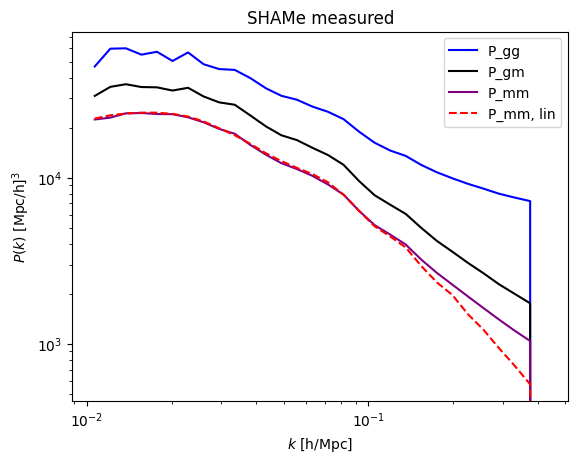

In [32]:
plt.title('SHAMe measured')
plt.plot(pk_obj_shame['k'], pk_obj_shame['pk'], label=f'P_gg', color='blue')
plt.plot(pgm_obj_shame['k'], pgm_obj_shame['pk'], label='P_gm', color='black')
plt.plot(pmm_obj_shame['k'], pmm_obj_shame['pk'], label='P_mm', color='purple', ls='-')
plt.plot(pmm_obj_shame_lin['k'], pmm_obj_shame_lin['pk'], label='P_mm, lin', color='red', ls='--')
plt.legend()
plt.xlabel(r'$k$ [h/Mpc]')
plt.ylabel(r'$P(k)$ [Mpc/h]$^3$')
plt.xscale('log')
plt.yscale('log')
plt.show()

# Load and plot

In [82]:
data_mode = 'muchisimocks'
statistics = ['pk', 'pgm']
#statistics = ['pk']

### train
# tag_params = '_p5_n10000'
# tag_biasparams = '_biaszen_p4_n10000'
# tag_noise = '_noise_unit_p5_n10000'
# tag_Anoise = '_Anmult_p5_n10000'
### test
tag_params = '_test_p5_n1000'
tag_biasparams = '_biaszen_p4_n1000'
#tag_noise = '_noise_unit_test_p5_n1000'
#tag_Anoise = '_Anmult_p5_n1000'
## cosmic variance (quijote)
# tag_params="_quijote_p0_n1000"
# tag_biasparams="_b1000_p0_n1"
# tag_noise="_noise_quijote_p0_n1000"
# tag_Anoise="_An1_p0_n1"
tag_noise = None
tag_Anoise = None
tag_datagen = ''
kwargs_data = {
    'tag_datagen': tag_datagen
}

tag_stats = f'_{"_".join(statistics)}'    
if tag_noise is None:
    tag_data = '_'+data_mode + tag_stats + tag_params + tag_biasparams + tag_datagen
else:
    tag_data = '_'+data_mode + tag_stats + tag_params + tag_biasparams + tag_noise + tag_Anoise + tag_datagen
k_arr, y_arr, y_err, idxs_params, params_df, param_dict_fixed, biasparams_df, biasparams_dict_fixed, Anoise_df, Anoise_dict_fixed, random_ints, random_ints_bias = \
            data_loader.load_data(data_mode, statistics, 
                                    tag_params, tag_biasparams,
                                    tag_noise=tag_noise, tag_Anoise=tag_Anoise,
                                    tag_data=tag_data,
                                    kwargs=kwargs_data)
            
print(y_arr[0].shape)
#print(y_arr[1].shape)

dir_statistics: /scratch/kstoreyf/muchisimocks/data/pks_mlib/pks_test_p5_n1000_biaszen_p4_n1000
Loading muchisimocks data from /scratch/kstoreyf/muchisimocks/data/pnns_mlib/pnns_test_p5_n1000


FileNotFoundError: [Errno 2] No such file or directory: '/scratch/kstoreyf/muchisimocks/data/pnns_mlib/pnns_test_p5_n1000'

In [12]:
theta, param_names = data_loader.param_dfs_to_theta(idxs_params, params_df, biasparams_df, Anoise_df=Anoise_df)

In [13]:
# unpack the stats
k_pk = k_arr[statistics.index('pk')]
y_pk = y_arr[statistics.index('pk')]

k_pgm = k_arr[statistics.index('pgm')]
y_pgm = y_arr[statistics.index('pgm')]

# k_bispec = k_arr[statistics.index('bispec')]
# y_bispec = y_arr[statistics.index('bispec')]


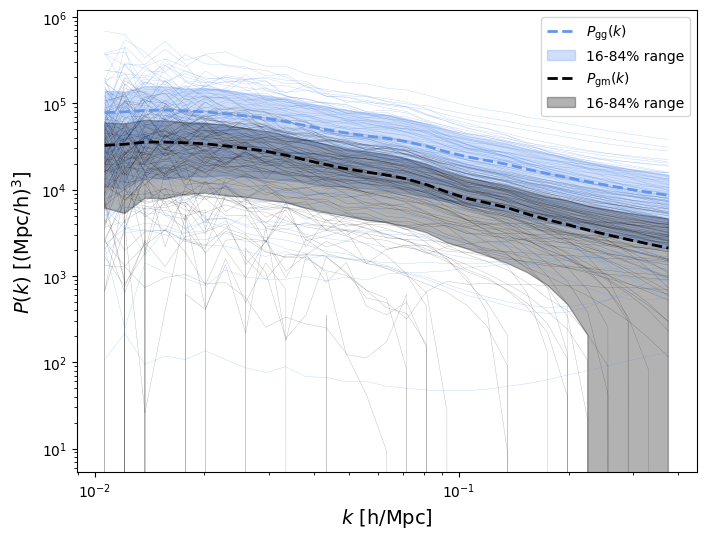

In [14]:

plt.figure(figsize=(8,6))

n_plot = np.min([100, y_pk.shape[0]])
first = True
for i in range(n_plot):
    label = None
    plt.plot(k_pk, y_pk[i], color='cornflowerblue', alpha=0.6, lw=0.2, label=label)
    plt.plot(k_pgm, y_pgm[i], color='black', alpha=0.4, lw=0.2, label=label)

mean = np.mean(y_pk, axis=0)
p16 = np.percentile(y_pk, 16, axis=0)
p84 = np.percentile(y_pk, 84, axis=0)
plt.plot(k_pk, mean, color='cornflowerblue', lw=2, ls='--', label=r'$P_{\rm gg}(k)$')
plt.fill_between(k_pk, p16, p84, color='cornflowerblue', alpha=0.3, label=r'16-84% range')

mean = np.mean(y_pgm, axis=0)
p16 = np.percentile(y_pgm, 16, axis=0)
p84 = np.percentile(y_pgm, 84, axis=0)
plt.plot(k_pgm, mean, color='black', lw=2, ls='--', label=r'$P_{\rm gm}(k)$')
plt.fill_between(k_pgm, p16, p84, color='black', alpha=0.3, label=r'16-84% range')

plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$k$ [h/Mpc]', fontsize=14)
plt.ylabel(r'$P(k)$ [(Mpc/h)$^3$]', fontsize=14)

plt.legend(fontsize=10)